# SCZ Correlation Demo


This notebook contrasts continuous-variable homodyne samples with and without the symplectic CZ transform. 
Sampling with the transform applies entangling CZ gates determined by the lattice adjacency and induces correlations across modes.

In [1]:
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


from flamingpy.codes.surface_code import SurfaceCode
from flamingpy.cv.ops import SCZ_apply
from flamingpy.noise import CVLayer, CVMacroLayer
from flamingpy.utils.viz import draw_EGraph


In [2]:
def sample_pairs(layer, coords, *, num_samples=4000, seed=1234):
    """Return homodyne samples with and without SCZ entanglement."""
    rng = np.random.default_rng(seed)
    layer.populate_states(rng=rng)
    adj = layer.egraph.adj_generator(sparse=False)
    if hasattr(adj, "toarray"):
        adj = adj.toarray()
    else:
        adj = np.asarray(adj)
    indices = [layer.egraph.to_indices[coord] for coord in coords]
    num_modes = layer._N
    raw = np.zeros((num_samples, len(indices)), dtype=np.float64)
    scz = np.zeros_like(raw)
    for i in range(num_samples):
        means = layer._means_sampler(rng=rng)
        covs = layer._covs_sampler()
        sample = rng.normal(means, covs)
        raw[i] = sample[num_modes:][indices]
        entangled = np.asarray(SCZ_apply(adj, sample.copy()))
        scz[i] = entangled[num_modes:][indices]
    return raw, scz

def corr_matrix(data):
    """Compute the column-wise correlation matrix."""
    if data.shape[1] == 1:
        return np.array([[1.0]])
    return np.corrcoef(data, rowvar=False)

def plot_correlations(raw_corr, scz_corr, labels):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    matrices = [(raw_corr, "Without SCZ"), (scz_corr, "With SCZ")]
    im = None
    for ax, (matrix, title) in zip(axes, matrices):
        im = ax.imshow(matrix, vmin=-1, vmax=1, cmap="coolwarm")
        ax.set_title(title)
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=45, ha="right")
        ax.set_yticks(range(len(labels)))
        ax.set_yticklabels(labels)
    if im is None:
        raise RuntimeError("No correlation matrices were plotted; check input data.")
    fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8, label="Correlation")
    fig.suptitle("Syndrome-mode p-homodyne correlations")
    fig.tight_layout()
    return fig

def build_syndrome_graph(all_coords, code_graph):
    """Return a graph where edges connect syndrome coords that share a data neighbor."""
    g = nx.Graph()
    g.add_nodes_from(all_coords)
    for s in all_coords:
        for data_node in code_graph.neighbors(s):
            for t in code_graph.neighbors(data_node):
                if t != s and t in g:
                    g.add_edge(s, t)
    return g

def select_connected_coords(all_coords, code_graph, count, seed=None):
    """Return up to `count` syndrome coords within one connected component."""
    if count is None or count < 0:
        return list(all_coords)
    if not all_coords or count == 0:
        return []
    if seed is None or seed not in all_coords:
        seed = all_coords[0]

    syndrome_graph = build_syndrome_graph(all_coords, code_graph)

    queue = deque([seed])
    seen = {seed}
    selected = []
    while queue and len(selected) < count:
        node = queue.popleft()
        selected.append(node)
        for nbr in syndrome_graph.neighbors(node):
            if nbr in seen:
                continue
            seen.add(nbr)
            queue.append(nbr)
    if len(selected) < count:
        print(f"Warning: only found {len(selected)} connected syndrome nodes (requested {count}).")
    return selected




Correlation matrix without SCZ:
 [[ 1.00000000e+00 -2.99637243e-03 -2.48901777e-03 -1.49281894e-03
   2.25701867e-04 -1.20240392e-02 -8.95711671e-03 -2.05860995e-02
   2.13463372e-02  3.84972863e-03 -1.11656558e-03 -1.05805171e-02]
 [-2.99637243e-03  1.00000000e+00  2.68009854e-02 -2.67363231e-03
   1.76738916e-02 -2.45654031e-03 -1.94811692e-02 -2.85659176e-02
  -2.70272608e-02 -3.03750104e-03 -1.22316026e-02  1.01493713e-03]
 [-2.48901777e-03  2.68009854e-02  1.00000000e+00  2.97950209e-03
  -9.60550791e-03  2.36845412e-03 -1.42281068e-03  1.40413771e-02
  -3.92958656e-04  3.94054896e-02  4.23848258e-03  1.12609189e-02]
 [-1.49281894e-03 -2.67363231e-03  2.97950209e-03  1.00000000e+00
   2.15574066e-02  3.31049941e-02 -6.36989282e-03  3.15610995e-03
  -1.13212823e-02 -5.83948253e-03  3.53152400e-03 -2.97899918e-02]
 [ 2.25701867e-04  1.76738916e-02 -9.60550791e-03  2.15574066e-02
   1.00000000e+00 -2.56602306e-02  5.84528051e-03 -3.59293100e-02
  -2.27048879e-02 -1.52880909e-02 -1.26

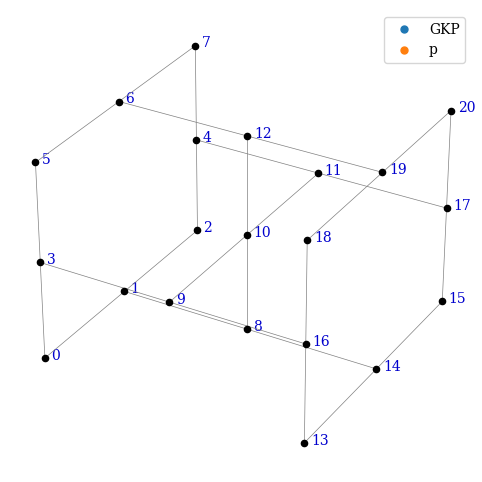

In [3]:
distance = 2
num_modes = None  # set to None to use all syndrome modes
#seed_coord = (0,1,1)  # optionally set e.g. (0, 1, 3)
delta = 0.2
num_samples = 4000
seed = 1

code = SurfaceCode(distance=distance, ec="primal", boundaries="open")

_ = draw_EGraph(
    code.graph,
    backend="matplotlib",          # 3D なら "plotly" も選べます
    color_nodes=("state", {"GKP": "tab:blue", "p": "tab:orange"}),
    label="index",                 # "bit_val" など別属性に変えてもよい
    legend=True,
    show_axes=False,
)

index_map = code.graph.index_generator()  # 座標 → index
inverse_map = code.graph.to_points        # index → 座標

#coord = inverse_map[38]                     # type: ignore # 例: index 3 の座標を取得
#neighbors = list(code.graph.neighbors(coord))

#print("index  corresponds to", coord)
#print("adjacent modes:", [(nbr, index_map[nbr]) for nbr in neighbors])

layer = CVLayer(code, delta=delta, sampling_order="initial")
all_coords = list(code.all_syndrome_coords)
syndrome_graph = build_syndrome_graph(all_coords, code.graph)
coords = all_coords
#coords = select_connected_coords(all_coords, code.graph, num_modes, seed=seed_coord)

raw, scz = sample_pairs(layer, coords, num_samples=num_samples, seed=seed)
raw_std = raw.std(axis=0)
scz_std = scz.std(axis=0)
keep = (raw_std > 1e-12) & (scz_std > 1e-12)
if not np.all(keep):
    dropped = len(keep) - int(np.count_nonzero(keep))
    print(f"Dropping {dropped} deterministic mode(s) with zero variance.")
    coords = [coord for coord, flag in zip(coords, keep) if flag]
    raw = raw[:, keep]
    scz = scz[:, keep]

raw_corr = corr_matrix(raw)
scz_corr = corr_matrix(scz)
labels = [str(coord) for coord in coords]
avg_increase = np.mean(np.abs(scz_corr - raw_corr))
print("Correlation matrix without SCZ:\n", raw_corr)
print("\nCorrelation matrix with SCZ:\n", scz_corr)
print("\nAverage absolute correlation increase:", avg_increase)
#for coord in coords:
#    print(coord, "-> index", index_map[coord])



In [4]:
from flamingpy.codes.surface_code import SurfaceCode

code = SurfaceCode(distance=2, ec="primal", boundaries="open")

# シンドローム（測定）ノード：今回は ec="primal" なので「primal 側」のものが all_syndrome_coords と一致
syndrome_coords = set(code.all_syndrome_coords)        # = set(code.primal_syndrome_coords)

# データ（メモリ）ノード：グラフ上の全ノードからシンドロームを除いたもの
data_coords = [coord for coord in code.graph.nodes if coord not in syndrome_coords]

print(f"syndrome ({len(syndrome_coords)} nodes):", sorted(index_map[c] for c in syndrome_coords)[:10], "…")
print(f"data ({len(data_coords)} nodes):", sorted(index_map[c] for c in data_coords)[:10], "…")

for coord in coords:
    print(coord, "-> index", index_map[coord])


syndrome (12 nodes): [0, 2, 5, 7, 8, 9, 11, 12, 13, 15] …
data (9 nodes): [1, 3, 4, 6, 10, 14, 16, 17, 19] …
(1, 2, 1) -> index 9
(2, 1, 1) -> index 13
(1, 3, 2) -> index 12
(0, 3, 1) -> index 5
(2, 3, 3) -> index 20
(0, 1, 3) -> index 2
(1, 2, 3) -> index 11
(2, 1, 3) -> index 15
(1, 1, 2) -> index 8
(0, 3, 3) -> index 7
(2, 3, 1) -> index 18
(0, 1, 1) -> index 0


/var/folders/qg/hz2bh__d5gj__c7sxhnxqxlw0000gn/T/ipykernel_32021/1265325556.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


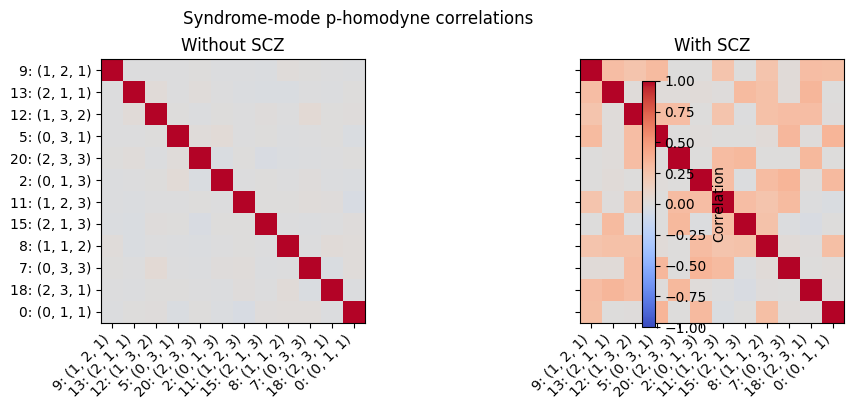

In [5]:
_ = plot_correlations(raw_corr, scz_corr, labels = [f"{index_map[c]}: {c}" for c in coords])
plt.show()


In [6]:
import numpy as np
from flamingpy.codes.surface_code import SurfaceCode
from flamingpy.noise import CVLayer
from flamingpy.decoders import decoder as dec

def run_trial(
    *,
    distance=3,
    delta=0.2,
    p_swap=0.0,
    boundaries="periodic",
    ec="primal",
    decoder_name="MWPM", # UF is also available
    rng=None,
):
    """1 回の QEC 試行を実行し、成功なら True を返す。"""
    if rng is None:
        rng = np.random.default_rng()

    decoder_key = decoder_name.upper()

    code = SurfaceCode(distance=distance, ec=ec, boundaries=boundaries)
    layer = CVLayer(code, delta=delta, p_swap=p_swap, sampling_order="initial")
    layer.apply_noise(rng=rng)

    if decoder_key == "MWPM":
        weight_options = {
            "method": "blueprint",
            "integer": True,
            "multiplier": 100,
            "delta": delta,
        }
    else:
        weight_options = None

    return bool(
        dec.correct(
            code=code,
            decoder=decoder_key,
            weight_options=weight_options,
            draw=False,
            sanity_check=False,
        )
    )

def estimate_error_rate(num_trials=100, **kwargs):
    rng = np.random.default_rng(kwargs.pop("seed", None))
    successes = sum(run_trial(rng=rng, **kwargs) for _ in range(num_trials))
    success_rate = successes / num_trials
    return success_rate, 1.0 - success_rate


In [7]:
params = dict(distance=2, delta=0.2, p_swap=0.0, boundaries="open")

success_rate, logical_error = estimate_error_rate(
    num_trials=3000, **params
)
print(
    f"success rate = {success_rate:.3f}, logical error rate = {logical_error:.3f}"
)


success rate = 0.834, logical error rate = 0.166


## Correlation-aware binning

In [79]:
import numpy as np
from itertools import product
from scipy.special import logsumexp
from collections import deque

LATTICE = np.sqrt(np.pi)

#def enumerate_candidates(x):
#    """各次元で切り捨て/切り上げの2候補（0,1）を組み合わせて全候補集合Qを生成"""
#    floors = np.floor(x / LATTICE)
#    ceils = floors + 1
#    for bits in product([0, 1], repeat=len(x)):
#        candidate = np.array([
#            floors[i] if b == 0 else ceils[i] for i, b in enumerate(bits)
#        ]) * LATTICE
#        parity = sum(bits) % 2
#        yield candidate, bits, parity

def enumerate_candidates(x):
    """GKP 格子上の候補点を列挙し、偶奇を返す."""
    base = np.floor(x / LATTICE).astype(int)

    for flips in product([0, 1], repeat=len(x)):
        indices = base + np.array(flips, dtype=int)  # 丸め後を整数で表現
        candidate = indices * LATTICE
        bit = indices % 2                     # 各軸の偶奇
        overall_parity = int(bit.sum() % 2)   # 任意: 全体の偶奇
        yield candidate, bit, overall_parity

def enumerate_candidates_with_indices(x):
    """Return candidate points on the GKP lattice and their integer indices."""
    base = np.floor(x / LATTICE).astype(int)

    for flips in product([0, 1], repeat=len(x)):
        indices = base + np.array(flips, dtype=int)
        candidate = indices * LATTICE
        parity = int(indices.sum() % 2)
        yield candidate, indices, parity

def mahalanobis_sq(x, q, inv_cov):
    diff = q - x
    return diff.T @ inv_cov @ diff


def local_neighborhood(graph, start, radius=1):
    """start を中心に半径 radius の BFS でシンドローム集合を返す。"""
    visited = {start}
    frontier = deque([(start, 0)])
    while frontier:
        node, dist = frontier.popleft()
        if dist == radius:
            continue
        for nbr in graph.neighbors(node):
            if nbr not in visited:
                visited.add(nbr)
                frontier.append((nbr, dist + 1))
    return visited


In [80]:
#class CorrAwareLayer(CVLayer):
#    def __init__(self, code, *, covariance, coords_order, delta, **kwargs):
#        super().__init__(code, delta=delta, translator=lambda xs: xs, **kwargs)
#        self._cov = covariance
#        self._inv_cov = np.linalg.inv(covariance)
#        self._coords_order = list(coords_order)
#
#    def inner_decoder(self):
#        coords = self._coords_order
#        x = np.array([self.code.graph.nodes[c]["hom_val_p"] for c in coords])
#
#        best_dist = np.inf
#        best_indices = None
#
#        for q, indices, parity in enumerate_candidates_with_indices(x):
#            d2 = mahalanobis_sq(x, q, self._inv_cov)
#            if d2 < best_dist:
#                best_dist = d2
#                best_indices = indices.copy()
#
#        if best_indices is None:
#            raise RuntimeError("No candidate generated. Check inputs.")
#
#        LATTICE = np.sqrt(np.pi)
#        q_best = best_indices * LATTICE
#        bits = (best_indices % 2).astype(int)
#
#        per_mode_weights = {}
#        M = 3
#        even_offsets = [2 * m for m in range(-M, M + 1)]
#        odd_offsets = [2 * m + 1 for m in range(-M, M + 1)]
#
#        for idx, coord in enumerate(coords):
#            even_logs = []
#            odd_logs = []
#
#            # 偶数側
#            for shift in even_offsets:
#                alt = best_indices.copy()
#                alt[idx] = best_indices[idx] + shift
#                q_alt = alt * LATTICE
#                diff = q_alt - x
#                logp = -0.5 * (diff @ self._inv_cov @ diff)
#                even_logs.append(logp)
#
#            # 奇数側
#            for shift in odd_offsets:
#                alt = best_indices.copy()
#                alt[idx] = best_indices[idx] + shift
#                q_alt = alt * LATTICE
#                diff = q_alt - x
#                logp = -0.5 * (diff @ self._inv_cov @ diff)
#                odd_logs.append(logp)
#
#            even_logsum = logsumexp(even_logs) if even_logs else -np.inf
#            odd_logsum = logsumexp(odd_logs) if odd_logs else -np.inf
#            llr = even_logsum - odd_logsum
#            p_err = 1.0 / (1.0 + np.exp(llr))
#            weight = -np.log(np.clip(p_err, 1e-12, 1.0))
#
#            self.code.graph.nodes[coord]["bit_val"] = int(bits[idx])
#            self.code.graph.nodes[coord]["llr"] = llr
#            self.code.graph.nodes[coord]["weight"] = weight
#
#

In [81]:
class CorrAwareLayer(CVLayer):
    def __init__(self, code, *, covariance, coords_order, syndrome_graph, delta, neighborhood_radius=2, M=3, **kwargs):
        super().__init__(code, delta=delta, translator=lambda xs: xs, **kwargs)
        self._cov = covariance
        self._coords_order = list(coords_order)
        self._syndrome_graph = syndrome_graph
        self._radius = neighborhood_radius
        self._M = M  # logsumexp に含めるシフトの範囲

    def inner_decoder(self):
        coords = self._coords_order
        x = np.array([self.code.graph.nodes[c]["hom_val_p"] for c in coords])
        LATTICE = np.sqrt(np.pi)

        even_offsets = [2 * m for m in range(-self._M, self._M + 1)]
        odd_offsets = [2 * m + 1 for m in range(-self._M, self._M + 1)]

        for center_idx, coord in enumerate(coords):
            # 1) 近傍ノード集合とローカル共分散
            neighborhood = local_neighborhood(self._syndrome_graph, coord, radius=self._radius)
            local_indices = [coords.index(n) for n in neighborhood]
            local_center = local_indices.index(center_idx)

            x_local = x[local_indices]
            cov_local = self._cov[np.ix_(local_indices, local_indices)]
            inv_cov_local = np.linalg.inv(cov_local)

            # 2) ローカル最尤候補
            best_dist = np.inf
            best_ints = None
            for q_local, ints_local, _ in enumerate_candidates_with_indices(x_local):
                d2_local = mahalanobis_sq(x_local, q_local, inv_cov_local)
                if d2_local < best_dist:
                    best_dist = d2_local
                    best_ints = ints_local.copy()

            if best_ints is None:
                raise RuntimeError("No candidate generated for local neighborhood.")

            # 中心モードのビット値
            bit_val = int(best_ints[local_center] % 2)

            # 3) ローカル LLR = log(sum_even) - log(sum_odd)
            even_logs = []
            odd_logs = []
            for shift in even_offsets:
                alt = best_ints.copy()
                alt[local_center] += shift
                diff = alt * LATTICE - x_local
                even_logs.append(-0.5 * (diff @ inv_cov_local @ diff))

            for shift in odd_offsets:
                alt = best_ints.copy()
                alt[local_center] += shift
                diff = alt * LATTICE - x_local
                odd_logs.append(-0.5 * (diff @ inv_cov_local @ diff))

            even_logsum = logsumexp(even_logs) if even_logs else -np.inf
            odd_logsum = logsumexp(odd_logs) if odd_logs else -np.inf
            llr = even_logsum - odd_logsum

            # 4) blueprint と同じ正の距離スケールへ
            p_err = 1.0 / (1.0 + np.exp(llr))
            weight = -np.log(np.clip(p_err, 1e-12, 1.0))

            # 5) ノード属性を更新
            self.code.graph.nodes[coord]["bit_val"] = bit_val
            self.code.graph.nodes[coord]["llr"] = llr
            self.code.graph.nodes[coord]["weight"] = weight


In [84]:
import numpy as np
from flamingpy.codes.surface_code import SurfaceCode
from flamingpy.decoders import decoder as dec

def run_trial_corr(
    *,
    distance=3,
    delta=0.2,
    p_swap=0.0,
    boundaries="periodic",
    ec="primal",
    decoder_name="MWPM",
    covariance=None,
    coords_order=None,
    weight_options=None,
    rng=None,
    weight_method="custom",
):
    """Correlation-aware inner decoderを使って1回のQEC試行を行い、成功なら True を返す。"""
    if covariance is None:
        raise ValueError("correlation-aware binning には covariance 行列が必須です。")
    if rng is None:
        rng = np.random.default_rng()

    decoder_key = decoder_name.upper()

    code = SurfaceCode(distance=distance, ec=ec, boundaries=boundaries)
    if coords_order is None:
        coords_order = list(code.all_syndrome_coords)
    if covariance.shape[0] != len(coords_order):
        raise ValueError("covariance 行列と coords_order のサイズが一致しません。")
    syndrome_graph = build_syndrome_graph(coords, code.graph)

    coord = coords_order[10]  # 調べたいシンドローム
    neigh = local_neighborhood(syndrome_graph, coord, radius=2)
    #print(coord, len(neigh), neigh)

    layer = CorrAwareLayer(
        code,
        delta=delta,
        covariance=covariance,
        coords_order=coords_order,
        p_swap=p_swap,
        sampling_order="initial",
        syndrome_graph=syndrome_graph,
    )
    layer.apply_noise(rng=rng)

    if weight_options is None:
        if decoder_key == "MWPM":
            if weight_method.lower() == "custom":
                weight_map = {coord: code.graph.nodes[coord]["weight"] for coord in coords_order}
                weight_options = {"method": "custom", "weight_map": weight_map}
            elif weight_method.lower() == "blueprint":
                weight_options = {
                    "method": "blueprint",
                    "integer": True,
                    "multiplier": 100,
                    "delta": delta,
                }
            else:
                raise ValueError(f"Unknown weight_method '{weight_method}'") 
        else:
            weight_options = {}

    return bool(
        dec.correct(
            code=code,
            decoder=decoder_key,
            weight_options=weight_options,
            draw=False,
            sanity_check=False,
        )
    )

def estimate_error_rate_corr(num_trials=100, *, covariance, coords_order, weight_options=None, seed=None, **kwargs):
    rng = np.random.default_rng(seed)
    successes = sum(
        run_trial_corr(
            rng=rng,
            covariance=covariance,
            coords_order=coords_order,
            weight_options=weight_options,
            **kwargs,
        )
        for _ in range(num_trials)
    )
    success_rate = successes / num_trials
    return success_rate, 1.0 - success_rate


In [85]:
DISTANCE = 2
DELTA = 0.2
BOUNDARIES = "open"

# 1) コードとシンドローム順を固定
code_cov = SurfaceCode(distance=DISTANCE, ec="primal", boundaries=BOUNDARIES)
layer_cov = CVLayer(code_cov, delta=DELTA, sampling_order="initial")
coords_order = list(code_cov.all_syndrome_coords)

# 2) SCZ 測定サンプルから共分散を作る
raw, scz = sample_pairs(layer_cov, coords_order, num_samples=5000, seed=0)
Sigma_meas = np.cov(scz.T, bias=True)
Sigma_meas += 1e-8 * np.eye(Sigma_meas.shape[0])           # 数値安定化
T = np.sqrt(np.pi) * np.eye(Sigma_meas.shape[0])           # 必要なら他の T
covariance = T @ Sigma_meas @ T.T

#covariance = np.eye(len(coords_order))
#print(covariance)

print(covariance.shape, len(coords_order))

(12, 12) 12


In [87]:
params = dict(distance=DISTANCE, delta=DELTA, p_swap=0.0, boundaries=BOUNDARIES, weight_method="blueprint")

success_rate, logical_error = estimate_error_rate_corr(
    num_trials=500,
    covariance=covariance,  # 事前に用意した行列
    decoder_name="MWPM",
    coords_order=coords_order,
    **params
)
print(f"success rate = {success_rate:.3f}, logical error rate = {logical_error:.3f}")


success rate = 0.862, logical error rate = 0.138


In [86]:
params = dict(distance=DISTANCE, delta=DELTA, p_swap=0.0, boundaries=BOUNDARIES)
success_rate, logical_error = estimate_error_rate(
    num_trials=500, **params
)
print(
    f"success rate = {success_rate:.3f}, logical error rate = {logical_error:.3f}"
)

success rate = 0.826, logical error rate = 0.174


$
p(x) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp!\left(-\frac{(x-\mu)^2}{2\sigma^2}\right) \\
\log p(x) = \text{const} - \tfrac{1}{2}(x-\mu)^{\mathrm T}\Sigma^{-1}(x-\mu) \\
log(sum(exp(x_i)))
$